- #  Configuração do Ambiente


In [37]:
!pip install pyspark google-cloud-bigquery matplotlib seaborn -q
!pip install pandas-gbq -q
!pip install pandas-gbq -q
import pandas as pd
import requests
from io import BytesIO
import pandas_gbq
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pyspark pandas-gbq db-dtypes -q
from google.colab import auth
auth.authenticate_user()


- # Configurações do BigQuery

In [8]:
project_id = 'leanttro-projeto-taxi'
tabela_destino_bq = 'dados_analise.dados_brutos'
colunas_para_usar = [
    'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'passenger_count', 'trip_distance', 'total_amount']


- ##  Verifica o Último Mês Carregado no BigQuery

In [9]:
print("Verificando o último mês carregado no BigQuery...")
start_date = '2023-01-01' # Data de início padrão se a tabela não existir
ultima_data_carregada_str = "Nenhuma"

try:
    sql_ultima_data = f"SELECT MAX(tpep_pickup_datetime) as ultima_data FROM `{project_id}.{tabela_destino_bq}`"
    df_ultima_data = pandas_gbq.read_gbq(sql_ultima_data, project_id=project_id)

    ultima_data_carregada = df_ultima_data['ultima_data'].iloc[0]

    if pd.notna(ultima_data_carregada):
        # Move a data de início para o primeiro dia do MÊS SEGUINTE
        start_date = (ultima_data_carregada + pd.offsets.MonthBegin(1)).strftime('%Y-%m-%d')
        ultima_data_carregada_str = ultima_data_carregada.strftime('%Y-%m-%d')

except Exception as e:
    print(f"AVISO: Não foi possível verificar a última data (tabela pode não existir ainda). Começando do início. Erro: {e}")

print(f"Último dado encontrado: {ultima_data_carregada_str}. Iniciando busca a partir de: {start_date}")


Verificando o último mês carregado no BigQuery...
Downloading: 100%|██████████|
Último dado encontrado: 2025-09-01. Iniciando busca a partir de: 2025-10-01


- ## Gera o Intervalo de Datas Dinamicamente

O fim é sempre o primeiro dia do mês atual, para garantir que só peguemos meses completos.

In [10]:
end_date = pd.to_datetime('today').replace(day=1).strftime('%Y-%m-%d')
datas_para_carregar = pd.date_range(start=start_date, end=end_date, freq='MS')

- ## Loop de Carga Incremental: (ADICIONAR NOVOS)

In [11]:
if datas_para_carregar.empty:
    print("\nNão há novos meses completos para carregar. Seus dados já estão atualizados!")
else:
    print(f"\nIniciando o carregamento de {len(datas_para_carregar)} novo(s) mese(s) de dados...\n")

    for data in datas_para_carregar:
        ano = data.strftime('%Y')
        mes = data.strftime('%m')

        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{ano}-{mes}.parquet"

        print(f"Processando: {ano}-{mes}")
        try:
            response = requests.get(url, timeout=20)
            response.raise_for_status()

            df_mensal = pd.read_parquet(BytesIO(response.content), columns=colunas_para_usar)
            df_mensal = df_mensal.dropna(subset=['tpep_pickup_datetime'])

            print(f"Enviando {len(df_mensal):,} linhas para o BigQuery...")

            pandas_gbq.to_gbq(
                df_mensal,
                destination_table=tabela_destino_bq,
                project_id=project_id,
                if_exists='append'
            )
            print(f"Dados de {ano}-{mes} carregados com sucesso!\n")

        except requests.exceptions.RequestException as e:
            print(f"AVISO: Falha ao baixar dados de {ano}-{mes}. O arquivo pode não existir ainda ou houve um erro de rede. Erro: {e}\n")

print("--- Carga de dados em lote concluída! ---")


Iniciando o carregamento de 1 novo(s) mese(s) de dados...

Processando: 2025-10
AVISO: Falha ao baixar dados de 2025-10. O arquivo pode não existir ainda ou houve um erro de rede. Erro: 403 Client Error: Forbidden for url: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-10.parquet

--- Carga de dados em lote concluída! ---


- ## Puxando tabela silver (dados_limpos) do GCP:

- # Configurações do BigQuery

In [12]:
spark = SparkSession.builder.appName("PySparkAmostraGrande_5M").getOrCreate()
project_id = 'leanttro-projeto-taxi'
table_id = 'dados_analise.dados_limpos'

- ## Movendo 2 milhões de registros pela rede do BigQuery para o Colab.

In [13]:
sql_query_amostra_grande = f"SELECT * FROM `{project_id}.{table_id}` LIMIT 2000000"
print(f"\nBuscando 2 milhões de registros do BigQuery para o Pandas...")
df_pandas = pandas_gbq.read_gbq(sql_query_amostra_grande, project_id=project_id)
print(f"Amostra de {len(df_pandas):,} linhas carregada com sucesso no Pandas.")
print("\nConvertendo para DataFrame PySpark...")
df_silver_spark = spark.createDataFrame(df_pandas)
df_silver_spark.cache()
print("DataFrame PySpark criado e pronto para uso!")


Buscando 2 milhões de registros do BigQuery para o Pandas...
Downloading: 100%|██████████|
Amostra de 2,000,000 linhas carregada com sucesso no Pandas.

Convertendo para DataFrame PySpark...
DataFrame PySpark criado e pronto para uso!


- # Criando DataFrame Gold:

In [14]:
from pyspark.sql.functions import count, sum, avg, round, col
df_gold_spark = df_silver_spark.groupBy("pickup_day_of_week", "pickup_hour") \
                            .agg(
                                count("*").alias("total_de_corridas"),
                                round(sum("total_amount"), 2).alias("faturamento_total"),
                                round(avg("total_amount"), 2).alias("faturamento_medio_por_corrida"),
                                round(avg("trip_distance"), 2).alias("distancia_media_percorrida"),
                                round(avg("trip_duration_minutes"), 2).alias("duracao_media_minutos"),
                                round(avg("passenger_count"), 2).alias("media_de_passageiros"),
                                round(avg(col("trip_distance") / (col("trip_duration_minutes") / 60)), 2).alias("velocidade_media_kmh")
                            )\
                            .filter(col("duracao_media_minutos") > 0)

df_gold_spark.cache()

print("DataFrame Gold criado com sucesso!")
df_gold_spark.show(5)

DataFrame Gold criado com sucesso!
+------------------+-----------+-----------------+-----------------+-----------------------------+--------------------------+---------------------+--------------------+--------------------+
|pickup_day_of_week|pickup_hour|total_de_corridas|faturamento_total|faturamento_medio_por_corrida|distancia_media_percorrida|duracao_media_minutos|media_de_passageiros|velocidade_media_kmh|
+------------------+-----------+-----------------+-----------------+-----------------------------+--------------------------+---------------------+--------------------+--------------------+
|                 4|         19|            20511|        591948.92|                        28.86|                       3.1|                15.01|                1.27|               10.63|
|                 3|          0|             3829|        148680.12|                        38.83|                      6.11|                16.19|                1.33|               19.25|
|              

- # Análise Exploratória 2 milhões de Dados:

- TOTAL DE CORRIDAS POR HORA

Calculando o total de corridas por hora...
Gerando o gráfico de barras...


/tmp/ipython-input-937171837.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pickup_hour', y='volume_total_corridas', data=corridas_por_hora_pd, palette='YlOrRd')


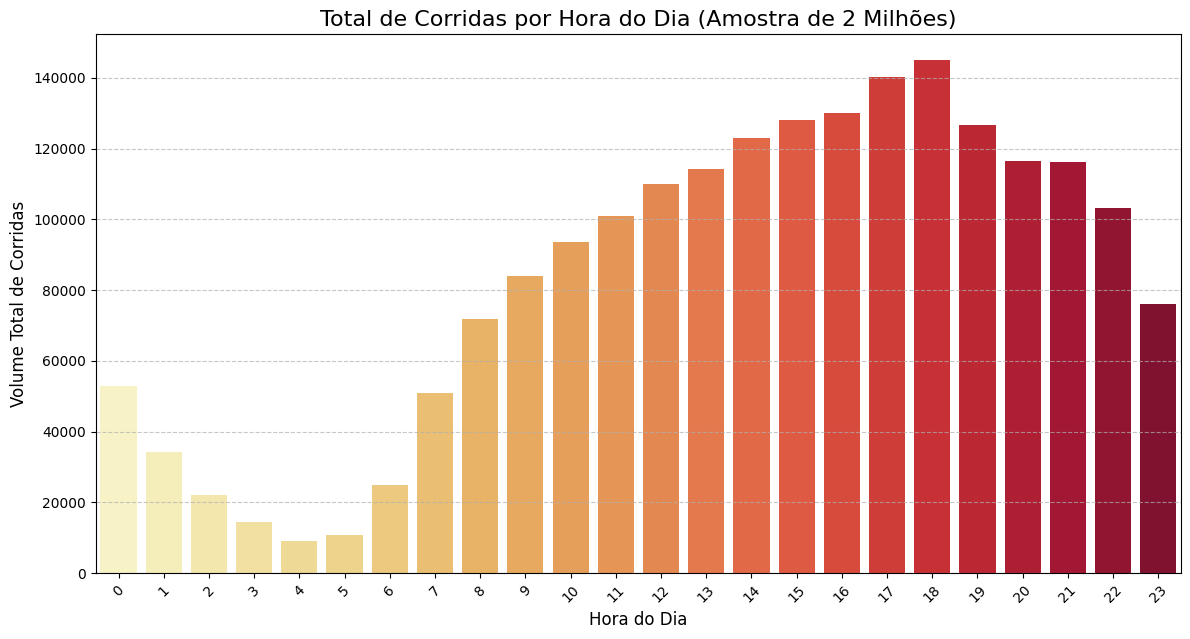

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Calculando o total de corridas por hora...")
corridas_por_hora = df_gold_spark.groupBy("pickup_hour") \
                               .agg(sum("total_de_corridas").alias("volume_total_corridas")) \
                               .orderBy("pickup_hour")

# Converter o resultado (que é pequeno, só 24 linhas) para Pandas para plotar
corridas_por_hora_pd = corridas_por_hora.toPandas()

# Gerar o gráfico
print("Gerando o gráfico de barras...")
plt.figure(figsize=(14, 7))
sns.barplot(x='pickup_hour', y='volume_total_corridas', data=corridas_por_hora_pd, palette='YlOrRd')
plt.title('Total de Corridas por Hora do Dia (Amostra de 2 Milhões)', fontsize=16)
plt.xlabel('Hora do Dia', fontsize=12)
plt.ylabel('Volume Total de Corridas', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- FATURAMENTO POR DIA DA SEMANA

Calculando faturamento por dia da semana...
Gerando o gráfico de pizza...


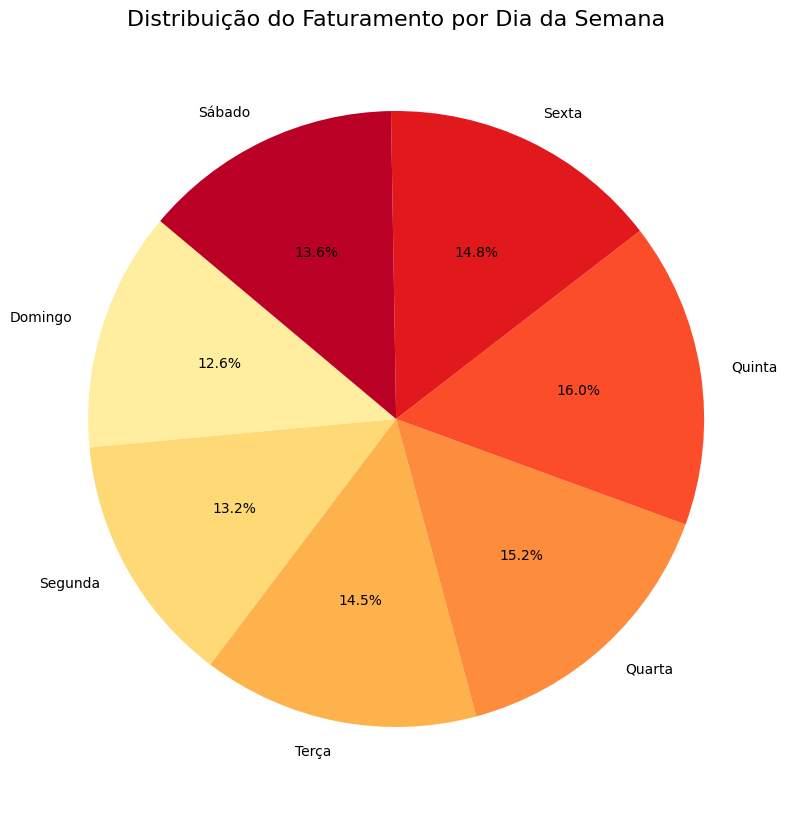

In [16]:
from pyspark.sql.functions import sum
import pandas as pd

print("Calculando faturamento por dia da semana...")
faturamento_por_dia = df_gold_spark.groupBy("pickup_day_of_week") \
                                   .agg(sum("faturamento_total").alias("faturamento")) \
                                   .orderBy("pickup_day_of_week")

# Converter para Pandas para plotar
faturamento_por_dia_pd = faturamento_por_dia.toPandas()

# Mapear os números dos dias para nomes para o gráfico ficar mais legível
dias_map = {1: 'Domingo', 2: 'Segunda', 3: 'Terça', 4: 'Quarta', 5: 'Quinta', 6: 'Sexta', 7: 'Sábado'}
faturamento_por_dia_pd['dia_nome'] = faturamento_por_dia_pd['pickup_day_of_week'].map(dias_map)


# Gerar o gráfico
print("Gerando o gráfico de pizza...")
plt.figure(figsize=(10, 10))
plt.pie(faturamento_por_dia_pd['faturamento'], labels=faturamento_por_dia_pd['dia_nome'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('YlOrRd', 7))
plt.title('Distribuição do Faturamento por Dia da Semana', fontsize=16)
plt.ylabel('') # Remove o label 'faturamento' do eixo y
plt.show()

- GRÁFICO COMBINADO DE TRÂNSITO

Calculando métricas de trânsito por hora...
Gerando o gráfico combinado...


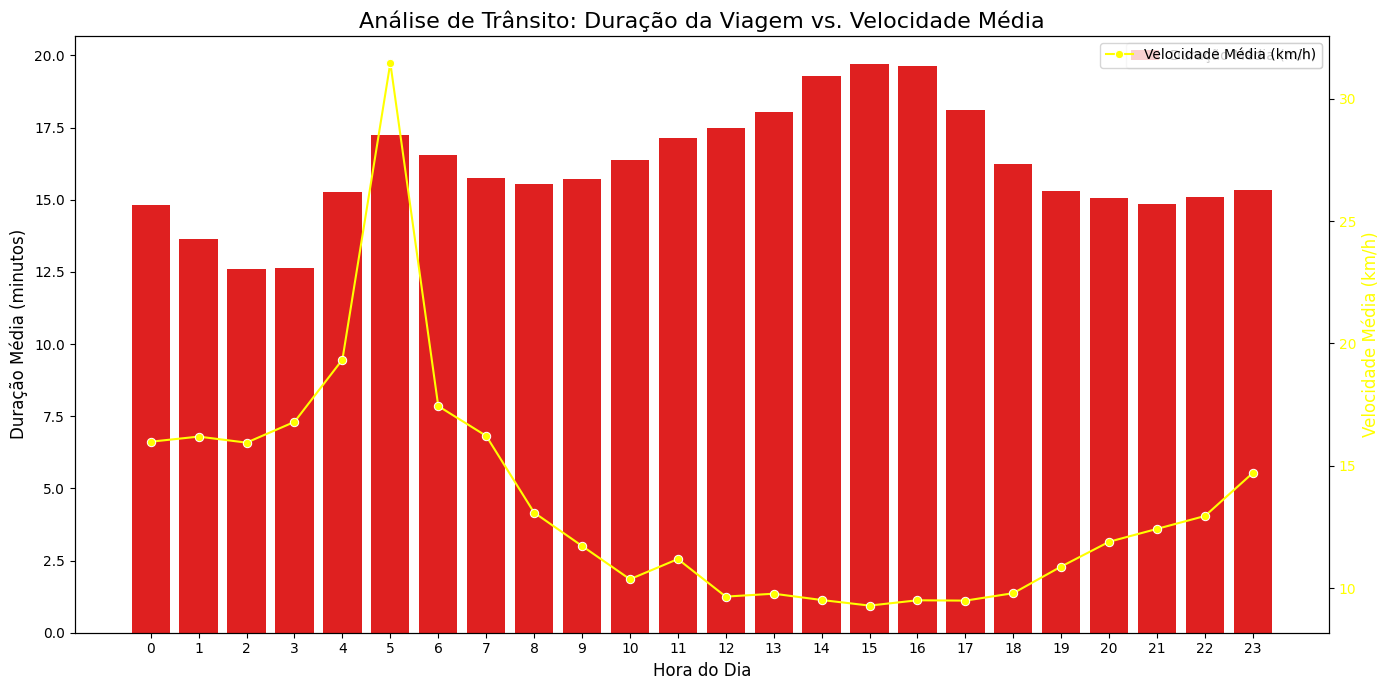

In [53]:
print("Calculando métricas de trânsito por hora...")
transito_por_hora = df_gold_spark.groupBy("pickup_hour") \
                               .agg(avg("duracao_media_minutos").alias("duracao_media"),
                                    avg("velocidade_media_kmh").alias("velocidade_media")) \
                               .orderBy("pickup_hour")

transito_por_hora_pd = transito_por_hora.toPandas()
print("Gerando o gráfico combinado...")
fig, ax1 = plt.subplots(figsize=(14, 7))

sns.barplot(x='pickup_hour', y='duracao_media', data=transito_por_hora_pd, color='red', ax=ax1, label='Duração Média (min)')
ax1.set_xlabel('Hora do Dia', fontsize=12)
ax1.set_ylabel('Duração Média (minutos)', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Criar um segundo eixo Y para a Velocidade
ax2 = ax1.twinx()
sns.lineplot(x='pickup_hour', y='velocidade_media', data=transito_por_hora_pd, color='yellow', marker='o', ax=ax2, label='Velocidade Média (km/h)')
ax2.set_ylabel('Velocidade Média (km/h)', fontsize=12, color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')

plt.title('Análise de Trânsito: Duração da Viagem vs. Velocidade Média', fontsize=16)
fig.tight_layout()
plt.show()

- Heatmap de Volume de Corridas


Gerando dados para o heatmap de volume de corridas...
Gerando o gráfico de heatmap...


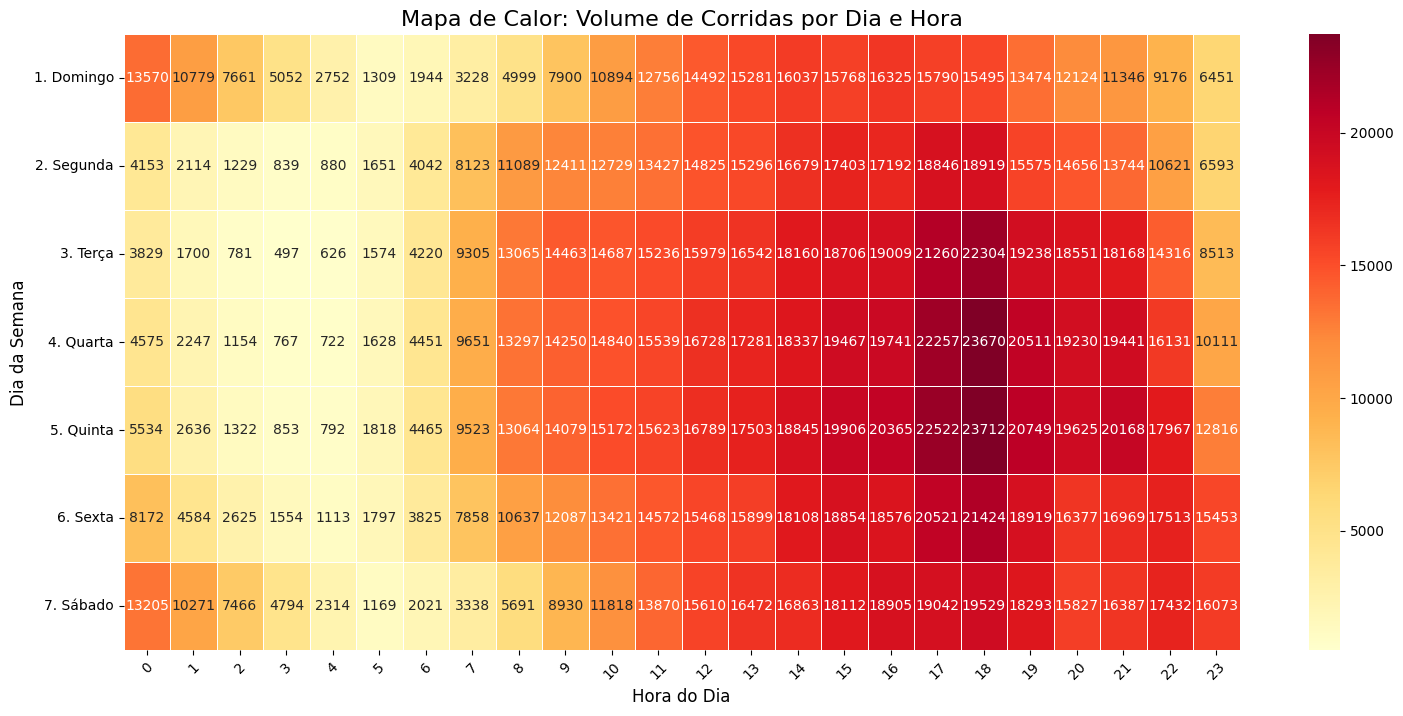

In [40]:
print("Gerando dados para o heatmap de volume de corridas...")
# Seleciona os dados, converte para Pandas e mapeia os dias da semana
heatmap_data_pd = df_gold_spark.select(\"pickup_day_of_week\", \"pickup_hour\", \"total_de_corridas\").toPandas()

dias_map = {1: '1. Domingo', 2: '2. Segunda', 3: '3. Terça', 4: '4. Quarta', 5: '5. Quinta', 6: '6. Sexta', 7: '7. Sábado'}
heatmap_data_pd['dia_da_semana'] = heatmap_data_pd['pickup_day_of_week'].map(dias_map)

# Cria a tabela pivot para o heatmap (dias nas linhas, horas nas colunas)
heatmap_pivot = heatmap_data_pd.pivot_table(index='dia_da_semana', columns='pickup_hour', values='total_de_corridas')

# Gerando o gráfico
print("Gerando o gráfico de heatmap...")
plt.figure(figsize=(18, 8))
sns.heatmap(heatmap_pivot, cmap='YlOrRd', annot=True, fmt='.0f', linewidths=.5)
plt.title('Mapa de Calor: Volume de Corridas por Dia e Hora', fontsize=16)
plt.xlabel('Hora do Dia', fontsize=12)
plt.ylabel('Dia da Semana', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

-  Top 10 Horários Mais Rentáveis

Calculando o ranking dos 10 horários mais rentáveis...
Gerando o gráfico de ranking...


/tmp/ipython-input-2524339471.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='faturamento_medio_por_corrida', y='horario', data=top_10_rentaveis_pd, palette='YlOrRd', orient='h')


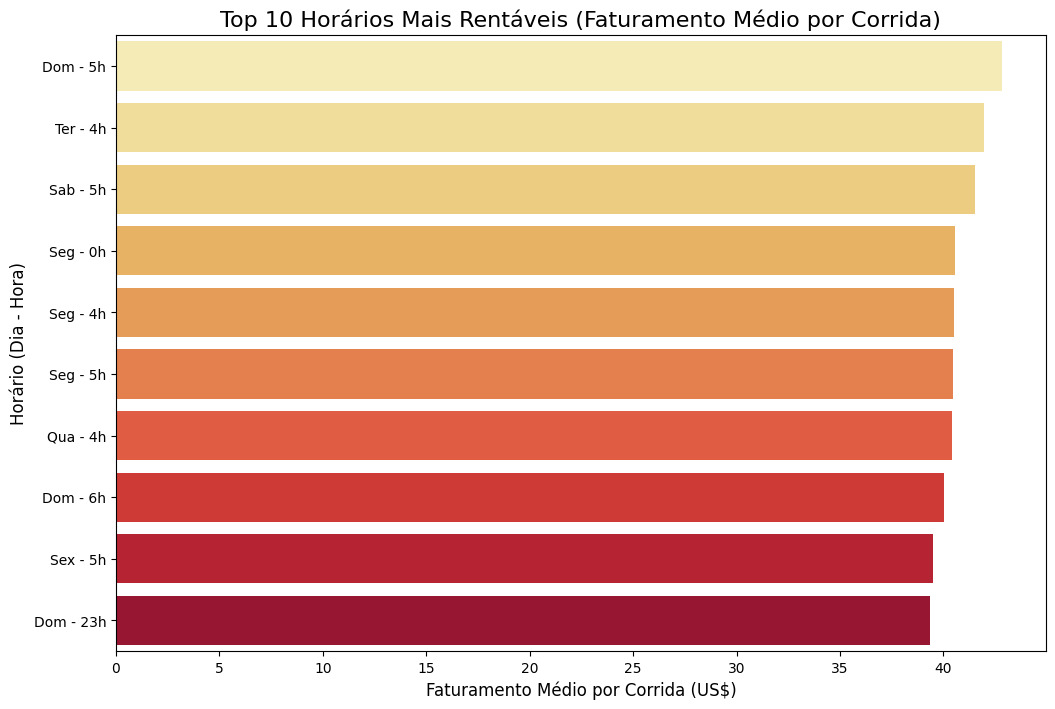

In [43]:
from pyspark.sql.functions import col, concat, lit, expr
print("Calculando o ranking dos 10 horários mais rentáveis...")

# Mapear os dias da semana para nomes
dias_map = {1: 'Dom', 2: 'Seg', 3: 'Ter', 4: 'Qua', 5: 'Qui', 6: 'Sex', 7: 'Sab'}
# Criando uma expressão SQL para o mapeamento dentro do Spark
mapping_expr = "CASE " + " ".join([f"WHEN pickup_day_of_week = {k} THEN '{v}'" for k, v in dias_map.items()]) + " END"

top_10_rentaveis = df_gold_spark.withColumn("dia_da_semana", expr(mapping_expr))\
                                .withColumn("horario", concat(col("dia_da_semana"), lit(" - "), col("pickup_hour"), lit("h")))\
                                .orderBy(col("faturamento_medio_por_corrida").desc())\
                                .select("horario", "faturamento_medio_por_corrida")\
                                .limit(10)

top_10_rentaveis_pd = top_10_rentaveis.toPandas()

# Gerando o gráfico de barras horizontais
print("Gerando o gráfico de ranking...")
plt.figure(figsize=(12, 8))
sns.barplot(x='faturamento_medio_por_corrida', y='horario', data=top_10_rentaveis_pd, palette='YlOrRd', orient='h')

plt.title('Top 10 Horários Mais Rentáveis (Faturamento Médio por Corrida)', fontsize=16)
plt.xlabel('Faturamento Médio por Corrida (US$)', fontsize=12)
plt.ylabel('Horário (Dia - Hora)', fontsize=12)
plt.show()

- Faturamento Total por Dia da Semana

Calculando o faturamento total por dia da semana...
Gerando o gráfico de ranking de faturamento diário...


/tmp/ipython-input-2862638168.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dia_nome', y='faturamento_total_dia', data=faturamento_dia_rank_pd, palette='YlOrRd')


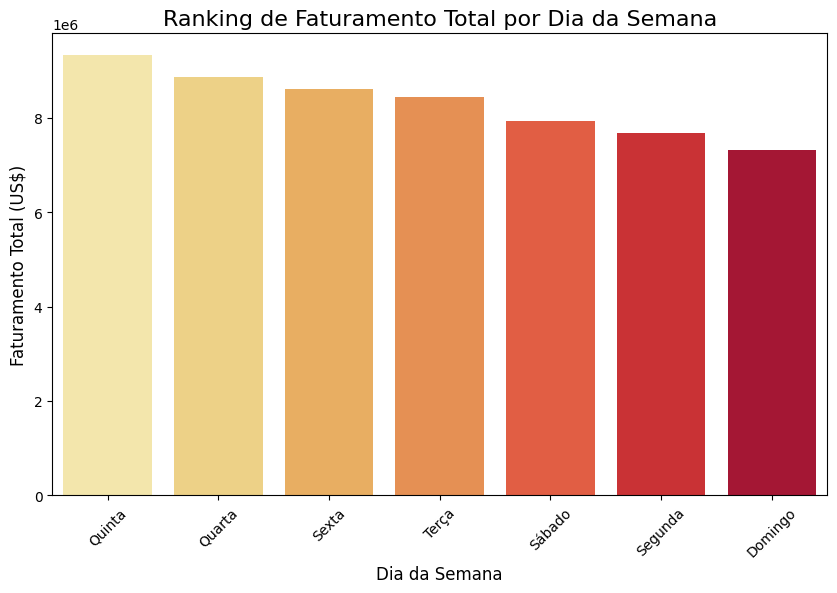

In [56]:
from pyspark.sql.functions import sum as spark_sum

print("Calculando o faturamento total por dia da semana...")
faturamento_dia_rank = df_gold_spark.groupBy("pickup_day_of_week")\
                                    .agg(spark_sum("faturamento_total").alias("faturamento_total_dia"))\
                                    .orderBy(col("faturamento_total_dia").desc()) # Ordena pelo faturamento

faturamento_dia_rank_pd = faturamento_dia_rank.toPandas()

# Mapeia os números dos dias para nomes
dias_map_full = {1: 'Domingo', 2: 'Segunda', 3: 'Terça', 4: 'Quarta', 5: 'Quinta', 6: 'Sexta', 7: 'Sábado'}
faturamento_dia_rank_pd['dia_nome'] = faturamento_dia_rank_pd['pickup_day_of_week'].map(dias_map_full)


# Gerando o gráfico de barras verticais
print("Gerando o gráfico de ranking de faturamento diário...")
plt.figure(figsize=(10, 6))
sns.barplot(x='dia_nome', y='faturamento_total_dia', data=faturamento_dia_rank_pd, palette='YlOrRd')

plt.title('Ranking de Faturamento Total por Dia da Semana', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Faturamento Total (US$)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

- Top 10 Horários de Maior Movimento

Calculando o ranking dos 10 horários de maior movimento...
Gerando o gráfico de ranking...


/tmp/ipython-input-1100194032.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_de_corridas', y='horario', data=top_10_movimento_pd, palette='YlOrRd', orient='h')


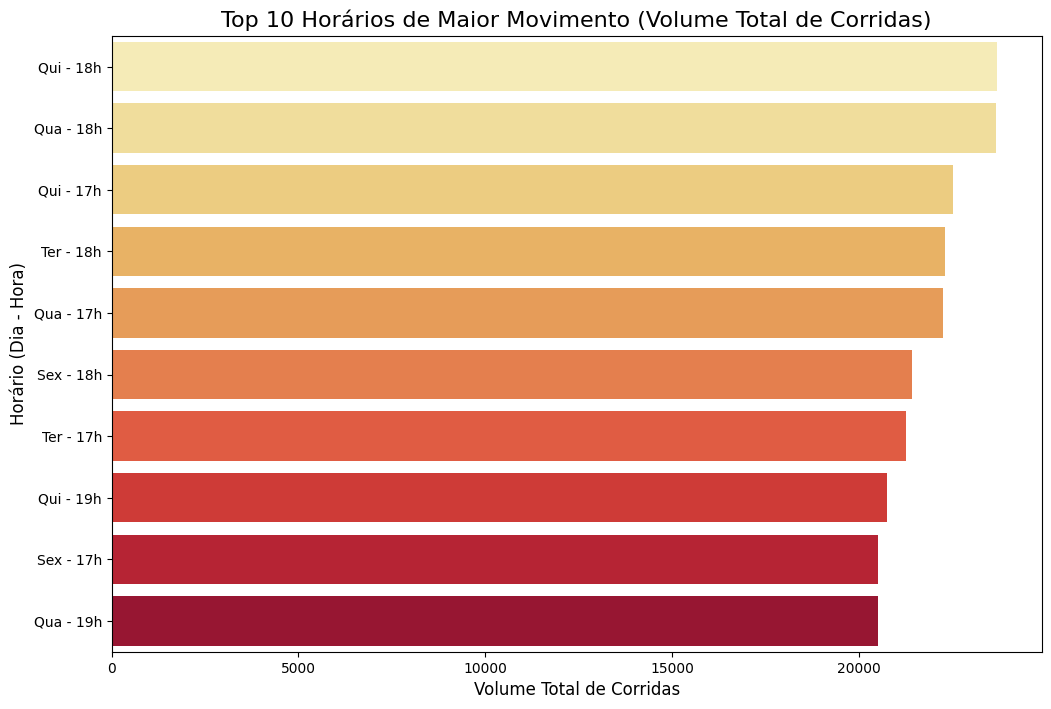

In [61]:
from pyspark.sql.functions import col, concat, lit, expr
print("Calculando o ranking dos 10 horários de maior movimento...")

top_10_movimento = df_gold_spark.withColumn("dia_da_semana", expr(mapping_expr)) \
                                .withColumn("horario", concat(col("dia_da_semana"), lit(" - "), col("pickup_hour"), lit("h"))) \
                                .orderBy(col("total_de_corridas").desc()) \
                                .select("horario", "total_de_corridas") \
                                .limit(10)

top_10_movimento_pd = top_10_movimento.toPandas()

# Gerando o gráfico
print("Gerando o gráfico de ranking...")
plt.figure(figsize=(12, 8))
sns.barplot(x='total_de_corridas', y='horario', data=top_10_movimento_pd, palette='YlOrRd', orient='h')

plt.title('Top 10 Horários de Maior Movimento (Volume Total de Corridas)', fontsize=16)
plt.xlabel('Volume Total de Corridas', fontsize=12)
plt.ylabel('Horário (Dia - Hora)', fontsize=12)
plt.show()

- Custo-Benefício (Duração vs. Faturamento)

Gerando dados para o scatter plot de Custo-Benefício...


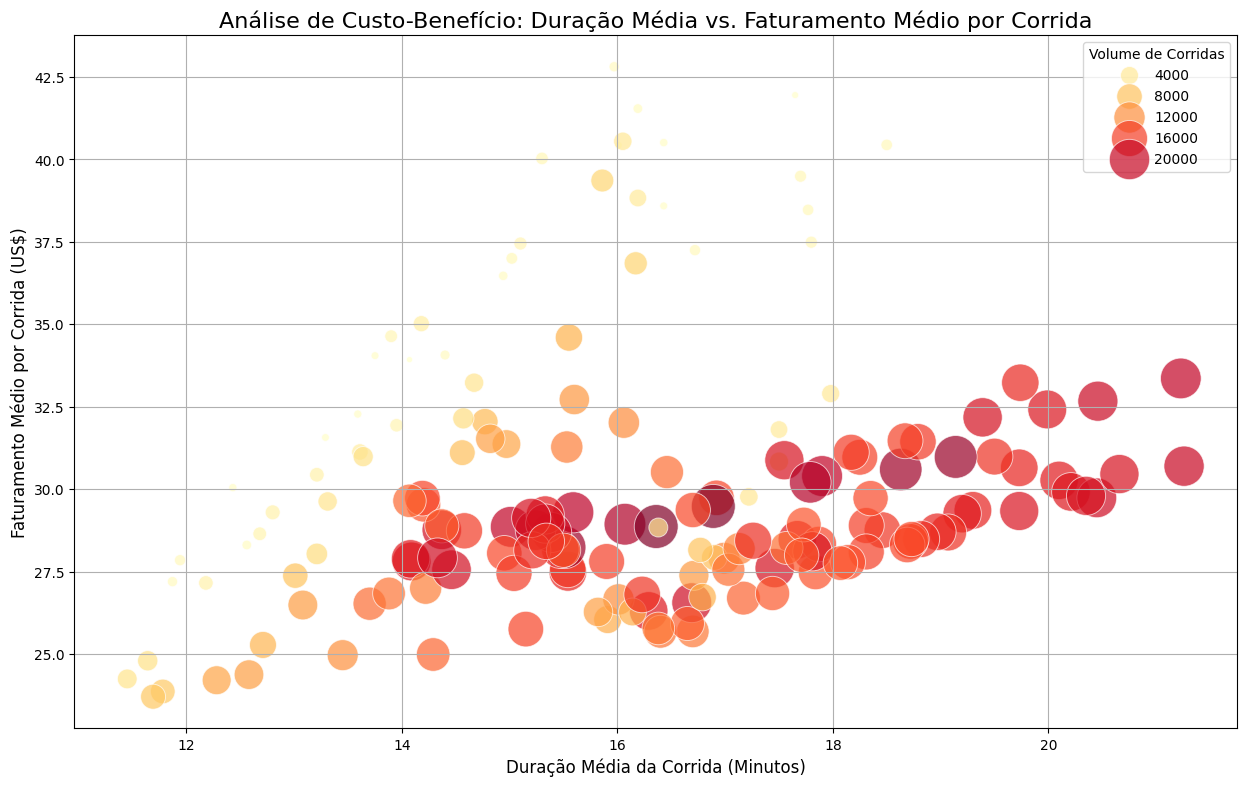

In [63]:
print("Gerando dados para o scatter plot de Custo-Benefício...")
custo_beneficio_pd = df_gold_spark.select("duracao_media_minutos", "faturamento_medio_por_corrida", "total_de_corridas").toPandas()

# Gerando o gráfico de dispersão
# O tamanho dos pontos (size) será proporcional ao volume de corridas
plt.figure(figsize=(15, 9))
sns.scatterplot(
    data=custo_beneficio_pd,
    x='duracao_media_minutos',
    y='faturamento_medio_por_corrida',
    size='total_de_corridas',  # Tamanho do ponto baseado no volume
    hue='total_de_corridas',   # Cor também baseada no volume
    palette='YlOrRd',
    sizes=(20, 1000),          # Define o intervalo de tamanho dos pontos
    alpha=0.7
)

plt.title('Análise de Custo-Benefício: Duração Média vs. Faturamento Médio por Corrida', fontsize=16)
plt.xlabel('Duração Média da Corrida (Minutos)', fontsize=12)
plt.ylabel('Faturamento Médio por Corrida (US$)', fontsize=12)
plt.legend(title='Volume de Corridas')
plt.grid(True)
plt.show()